In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import pickle
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)


def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))
            
def load_obj(source):
    with open(source,'rb') as f:
        return pickle.load(f)

2023-06-07 14:18:45.833827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2023-06-07 14:18:45.833858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/llr/cms/motta/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes,

In [2]:
options = {
    'v'          : '16',
    'date'       : '2023_05_28',
    'inTagIdent' : '_QP',
    'inTagCalib' : '_QP',
    'caloClNxM'  : '5x9',
    'sparsity'   : 0.5
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/TauMinator_CE_cltw'+options['caloClNxM']+'_Training'+options['inTagIdent']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1 = np.load(indir+'/tensors/images_valid.npz')['arr_0']
X2 = np.load(indir+'/tensors/posits_valid.npz')['arr_0']
X3 = np.load(indir+'/tensors/shapes_valid.npz')['arr_0']
Y  = np.load(indir+'/tensors/target_valid.npz')['arr_0']
Yid  = Y[:,1].reshape(-1,1)
Ycal = Y[:,0].reshape(-1,1)

# scale features of the cl3ds
scaler = load_obj('/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']+'/CL3D_features_scaler/cl3d_features_scaler.pkl')
X3 = scaler.transform(X3)

# select correct cl3d features
features2use = [0, 2, 4, 5, 9, 11, 12, 16]
X3 = np.ascontiguousarray(X3[:,features2use])

X1_id_reduced = X1[:3000]
X2_id_reduced = X2[:3000]
X3_id_reduced = X3[:3000]
Y_id_reduced = Yid[:3000]

# select only taus
tau_sel = Yid.reshape(1,-1)[0] > 0
X1_cal = X1[tau_sel]
X2_cal = X2[tau_sel]
X3_cal = X3[tau_sel]
Y_cal = Y[tau_sel]
Ycal = Ycal[tau_sel]

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
X3_cal_reduced = X3_cal[:3000]
Y_cal_reduced = Ycal[:3000]

Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [5]:
# quantized and pruned models
QCNN = keras.models.load_model(indir+'/CNNmodel', compile=False)
QDNNident = keras.models.load_model(indir+'/ID_DNNmodel', compile=False)
QDNNcalib = keras.models.load_model(indir+'/CAL_DNNmodel', compile=False)

2023-06-07 14:18:50.868650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2023-06-07 14:18:50.868699: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-07 14:18:50.868721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (llrgrhgtrig.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-06-07 14:18:50.869022: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical

In [6]:
# original floating point model without pruning
CNN_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CE_cltw5x9_Training/CNNmodel', compile=False)
DNNident_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CE_cltw5x9_Training/ID_DNNmodel', compile=False)
DNNcalib_FullFloat= keras.models.load_model('/data_CMS/cms/motta/Phase2L1T/2023_05_24_v15/TauMinator_CE_cltw5x9_Training/CAL_DNNmodel', compile=False)

# QUANTIZED MODELS ONLY

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: littleMan, layer type: Concatenate
Layer name: AssociatedCl3dFeatures, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_ufixed<10,8>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}

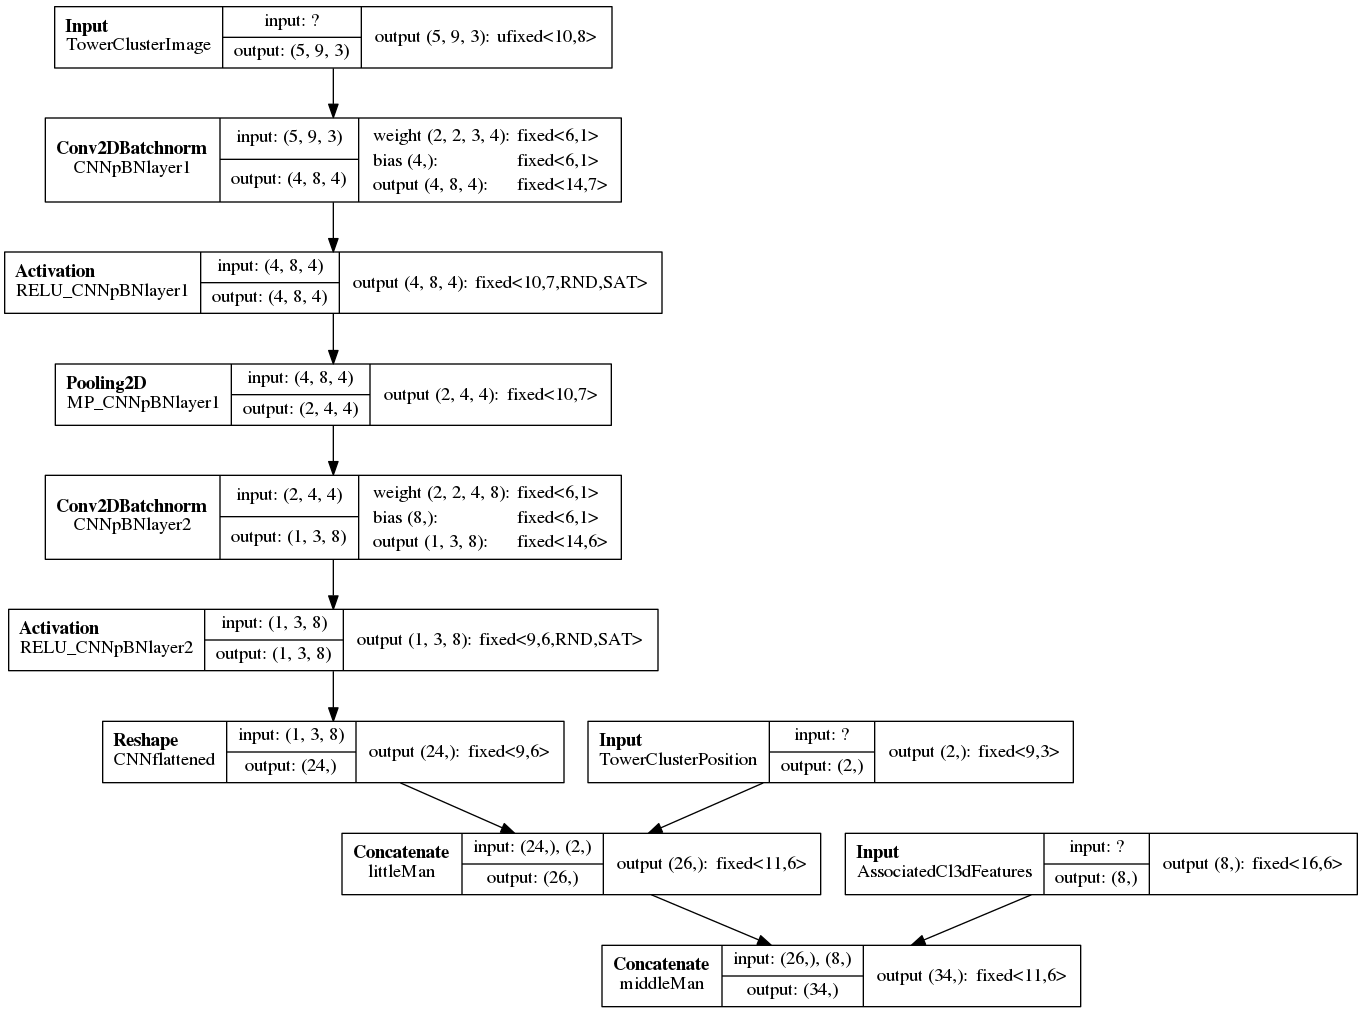

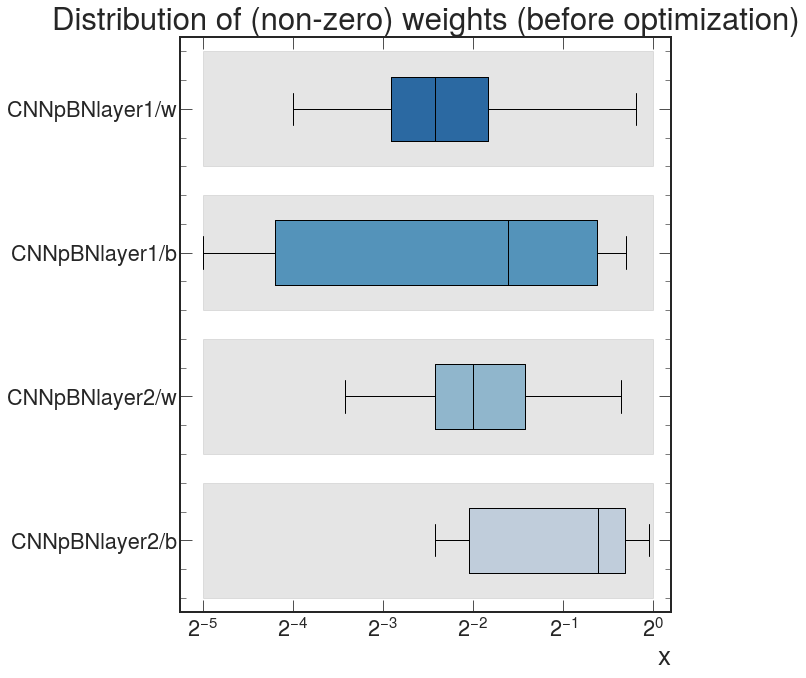

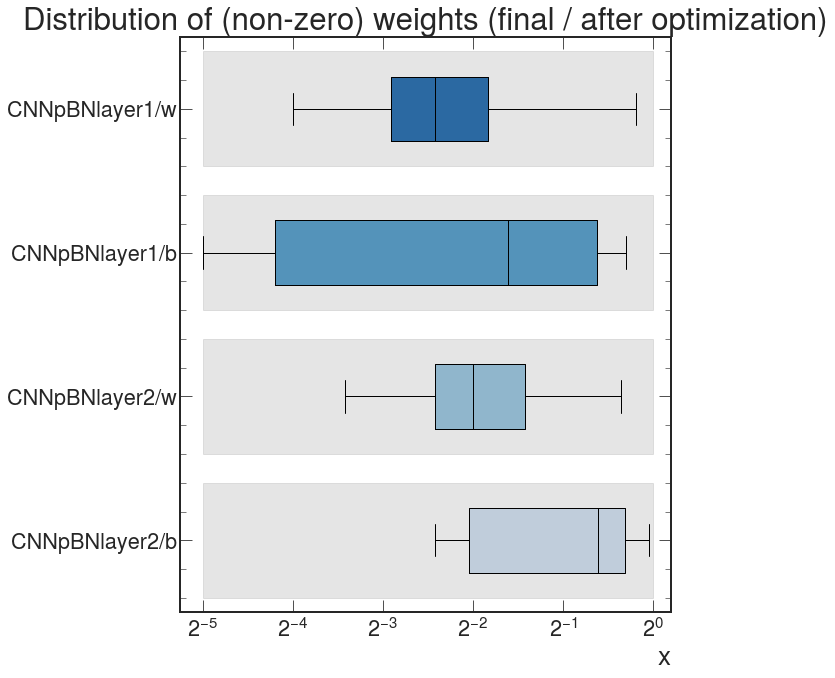

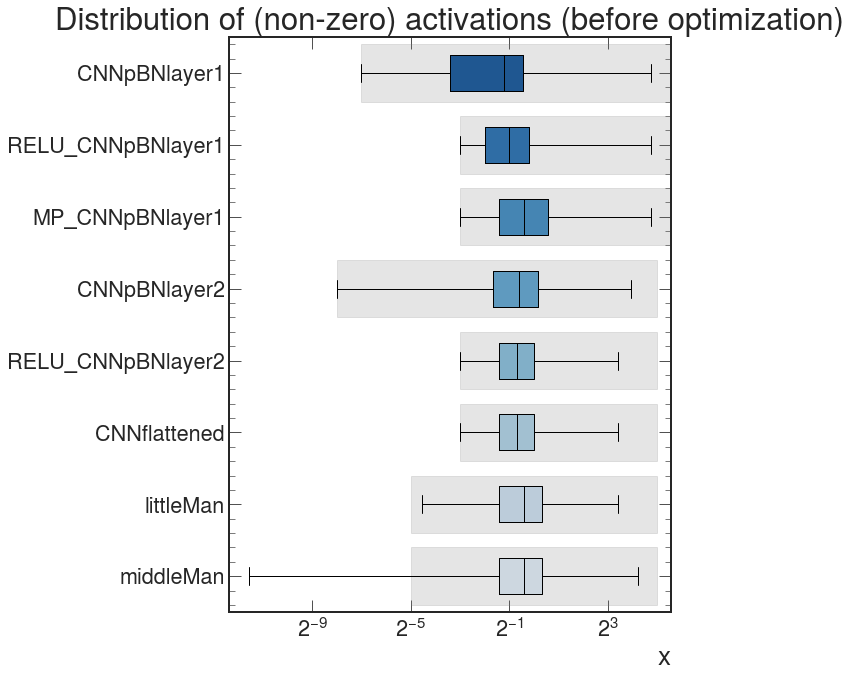

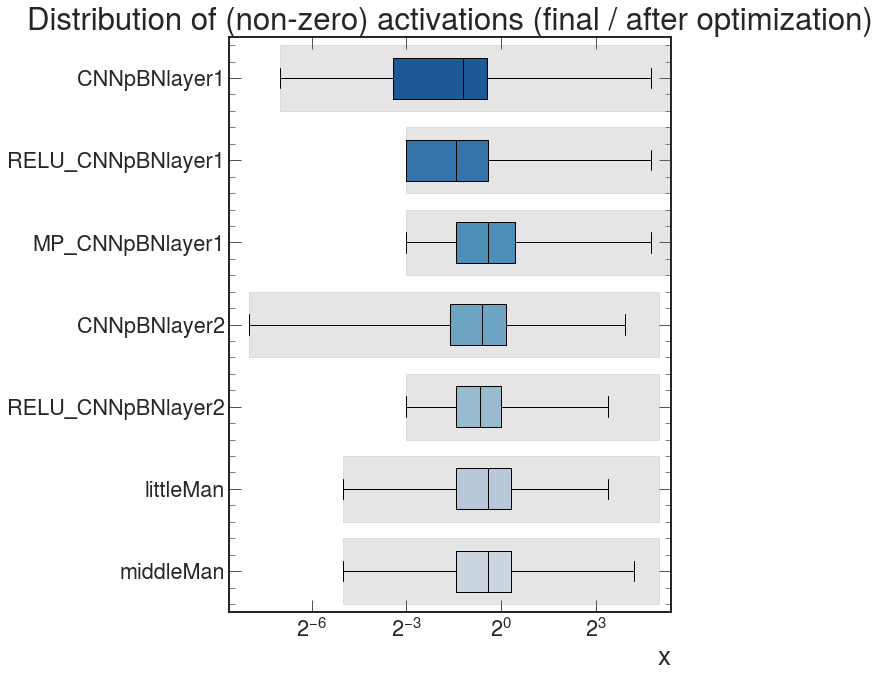

In [7]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_ufixed<10,8>'
QCNN_hls_cfg['LayerName']['TowerClusterPosition']['Precision'] = 'ap_fixed<9,3>'
QCNN_hls_cfg['LayerName']['AssociatedCl3dFeatures']['Precision'] = 'ap_fixed<16,6>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['ParallelizationFactor'] = 4
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['weight'] = 'ap_fixed<5,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['bias'] = 'ap_fixed<6,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<14,7>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<14,7>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<10,7>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['MP_CNNpBNlayer1']['Precision'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['weight'] = 'ap_fixed<5,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['bias'] = 'ap_fixed<6,1>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<14,6>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<14,6>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<9,6>'

QCNN_hls_cfg['LayerName']['littleMan']['Precision'] = 'ap_fixed<11,6>'
QCNN_hls_cfg['LayerName']['littleMan']['Strategy'] = 'Stable'

QCNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']      = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']   = QCNN_hls_cfg
QCNN_cfg['KerasModel']  = QCNN
QCNN_cfg['OutputDir']   = indir+'/CNNmodel_HLS/'
# QCNN_cfg['ProjectName'] = 'TauMinator_CE_CNNmodel'
QCNN_cfg['Part']        = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart']  = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced,X3_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: middleMan, layer type: Input
Layer name: IDlayer1, layer type: QDense
  -> Activation (linear), layer name: IDlayer1
Layer name: RELU_IDlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_IDlayer1
Layer name: IDlayer2, layer type: QDense
  -> Activation (linear), layer name: IDlayer2
Layer name: RELU_IDlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_IDlayer2
Layer name: IDout, layer type: QDense
  -> Activation (linear), layer name: IDout
Layer name: sigmoid_IDout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'middleMan': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'IDlayer1': {'Precision': {'weight': 'ap_fixed<3,1>', 'accum': 'ap_fixed<13,6>', 'result': 'ap_fixed<8,6>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'IDlayer1_linear': {

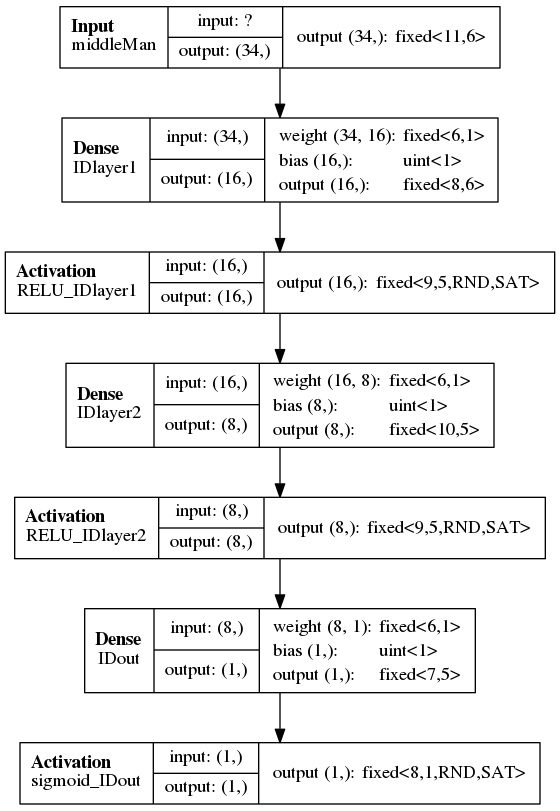

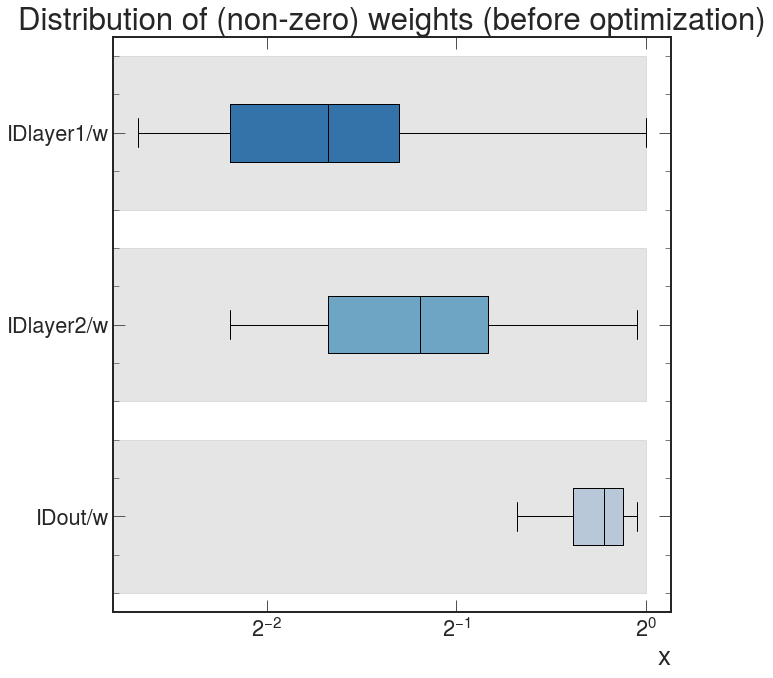

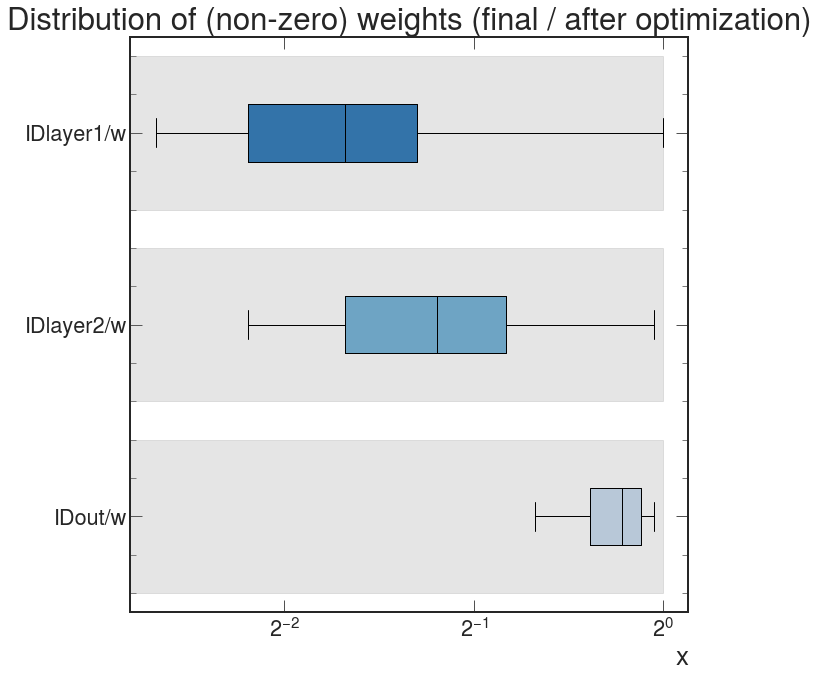

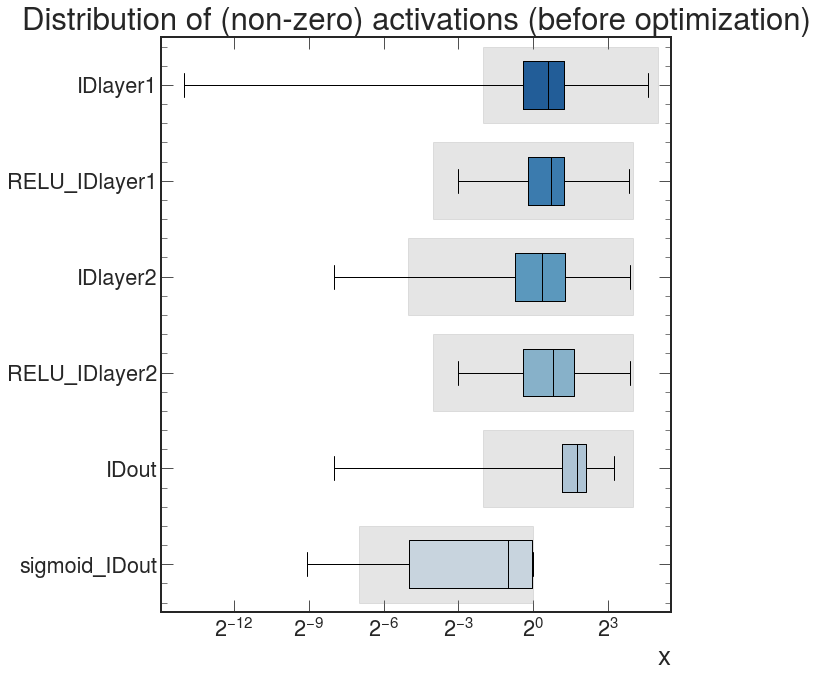

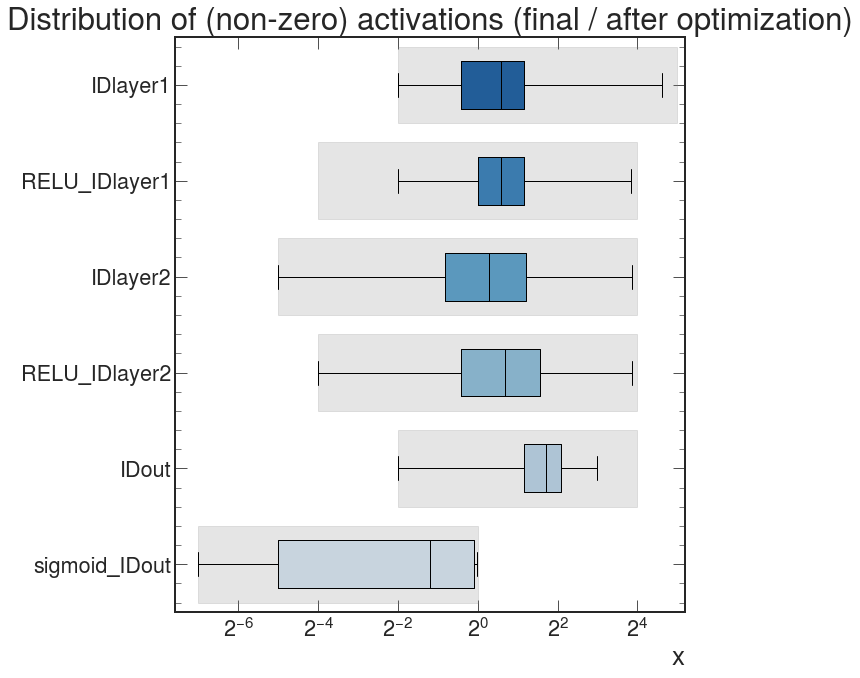

In [8]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    
id_QDNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'

id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['weight'] = 'ap_fixed<3,1>'
id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['accum'] = 'ap_fixed<13,6>'
id_QDNN_hls_cfg['LayerName']['IDlayer1']['Precision']['result'] = 'ap_fixed<8,6>'
id_QDNN_hls_cfg['LayerName']['RELU_IDlayer1']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['weight'] = 'ap_fixed<3,1>'
id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['accum'] = 'ap_fixed<11,6>'
id_QDNN_hls_cfg['LayerName']['IDlayer2']['Precision']['result'] = 'ap_fixed<10,5>'
id_QDNN_hls_cfg['LayerName']['RELU_IDlayer2']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['weight'] = 'ap_fixed<2,1>'
id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['accum'] = 'ap_fixed<7,4>'
id_QDNN_hls_cfg['LayerName']['IDout']['Precision']['result'] = 'ap_fixed<7,5>'

id_QDNN_hls_cfg['LayerName']['sigmoid_IDout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_IDout']['Strategy'] = 'Stable'


print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']      = 'io_parallel'
id_QDNN_cfg['HLSConfig']   = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel']  = QDNNident
id_QDNN_cfg['OutputDir']   = indir+'/ID_DNNmodel_HLS/'
# id_QDNN_cfg['ProjectName'] = 'TauMinator_CE_DNNident'
id_QDNN_cfg['Part']        = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart']  = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced,X3_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: middleMan, layer type: Input
Layer name: CALlayer1, layer type: QDense
  -> Activation (linear), layer name: CALlayer1
Layer name: RELU_CALlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CALlayer1
Layer name: CALlayer2, layer type: QDense
  -> Activation (linear), layer name: CALlayer2
Layer name: RELU_CALlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CALlayer2
Layer name: CALout, layer type: QDense
  -> Activation (linear), layer name: CALout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'middleMan': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'CALlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'accum': 'ap_fixed<16,5>', 'result': 'ap_fixed<14,6>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'CALlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'Reuse

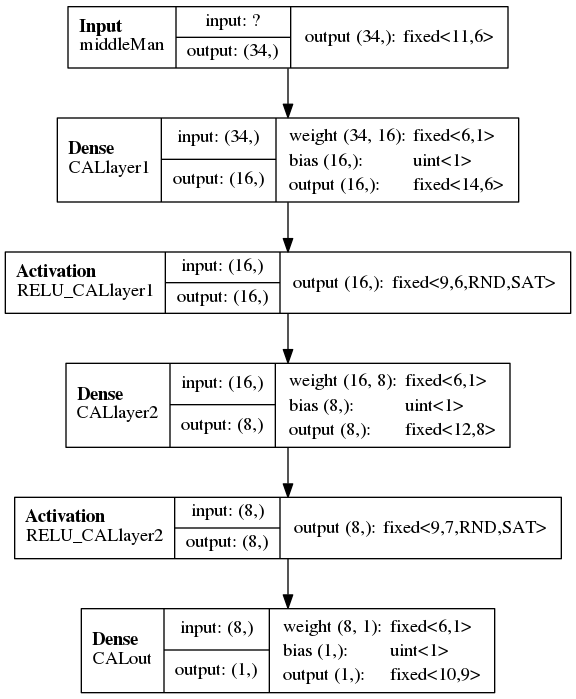

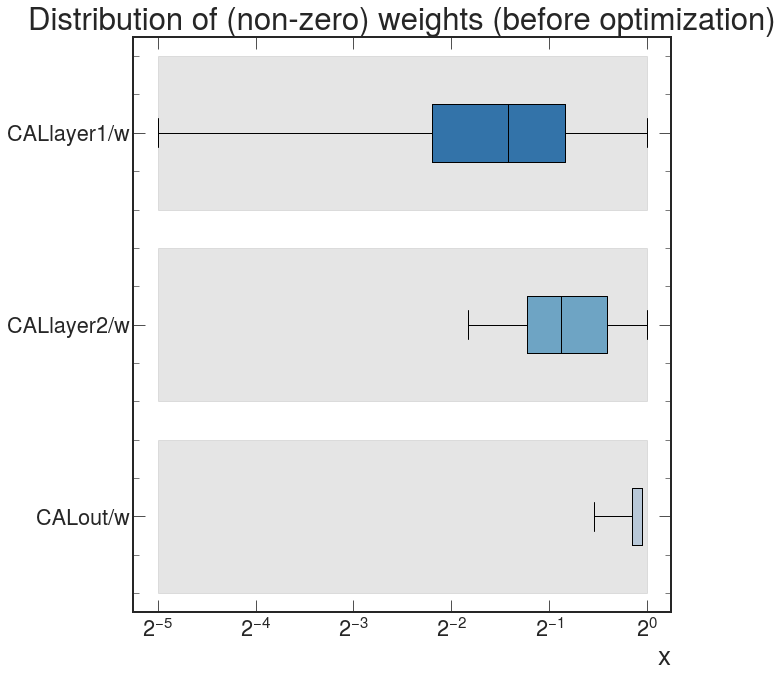

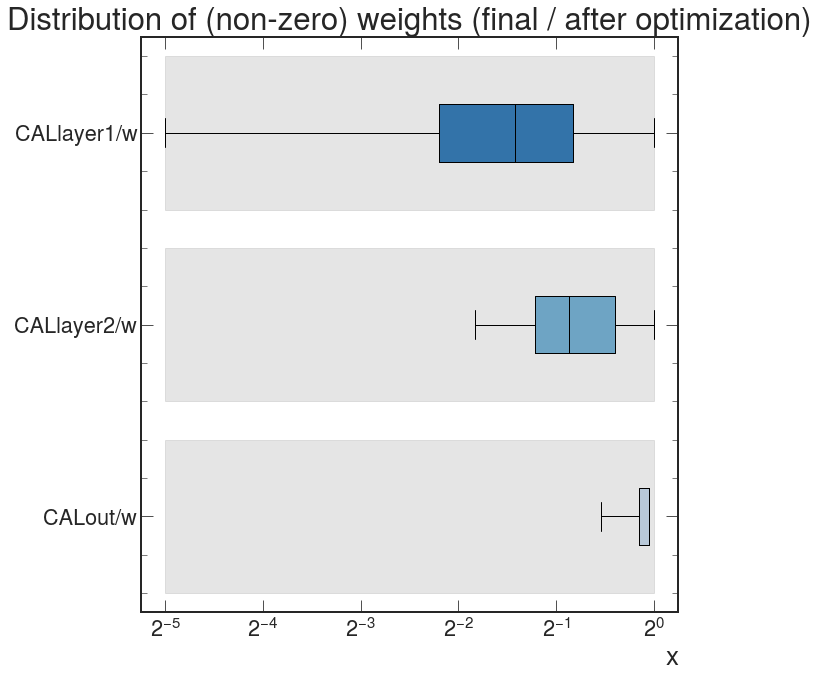

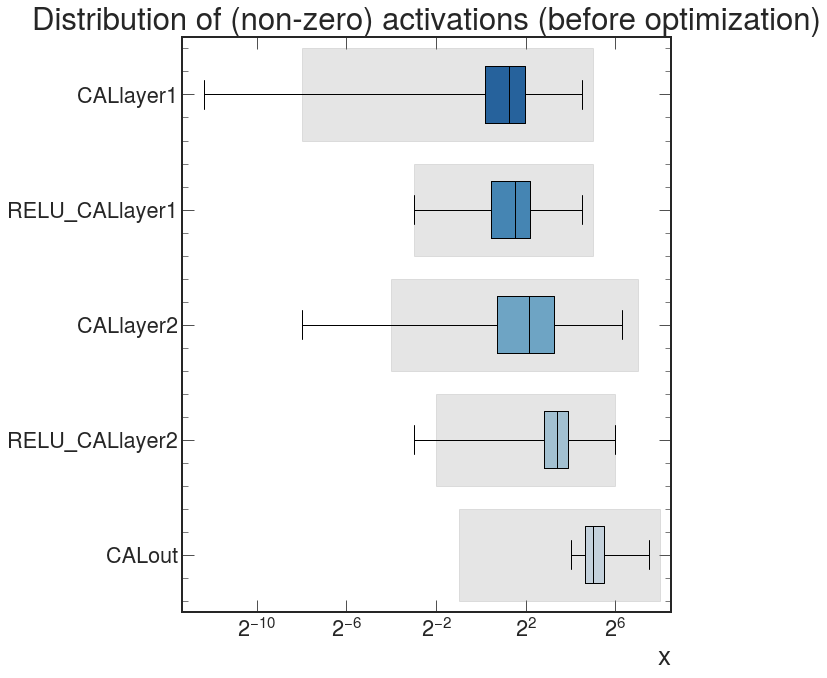

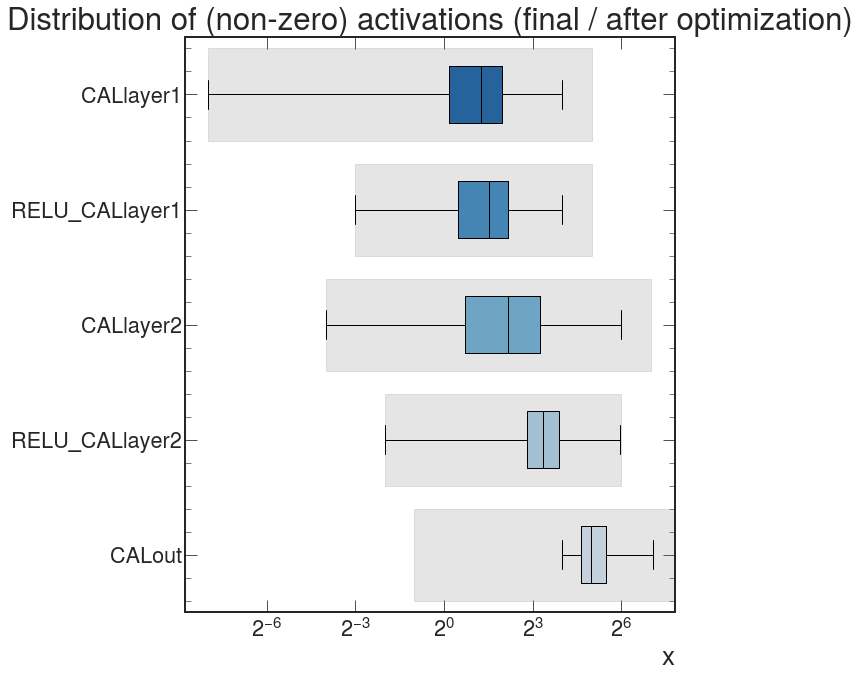

In [9]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'

cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['accum'] = 'ap_fixed<16,5>'
cal_QDNN_hls_cfg['LayerName']['CALlayer1']['Precision']['result'] = 'ap_fixed<14,6>'
cal_QDNN_hls_cfg['LayerName']['RELU_CALlayer1']['Precision'] = 'ap_fixed<9,6>'

cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['weight'] = 'ap_fixed<3,1>'
cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['accum'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['CALlayer2']['Precision']['result'] = 'ap_fixed<12,8>'
cal_QDNN_hls_cfg['LayerName']['RELU_CALlayer2']['Precision'] = 'ap_fixed<9,7>'

cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['weight'] = 'ap_fixed<2,1>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['accum'] = 'ap_fixed<12,9>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Precision']['result'] = 'ap_fixed<10,9>'
cal_QDNN_hls_cfg['LayerName']['CALout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']      = 'io_parallel'
cal_QDNN_cfg['HLSConfig']   = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel']  = QDNNcalib
cal_QDNN_cfg['OutputDir']   = indir+'/CAL_DNNmodel_HLS/'
# cal_QDNN_cfg['ProjectName'] = 'TauMinator_CE_DNNcalib'
cal_QDNN_cfg['Part']        = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart']  = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced,X3_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [10]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Floating Point ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS Firmware ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=24)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

In [11]:
y_ident_ff = DNNident_FullFloat.predict(CNN_FullFloat.predict([X1, X2, X3]))
y_calib_ff = DNNcalib_FullFloat.predict(CNN_FullFloat.predict([X1_cal, X2_cal, X3_cal]))

In [12]:
y_ident_q        = QDNNident.predict(QCNN.predict([X1, X2, X3]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1, X2, X3]))

In [13]:
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal, X3_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal, X3_cal]))

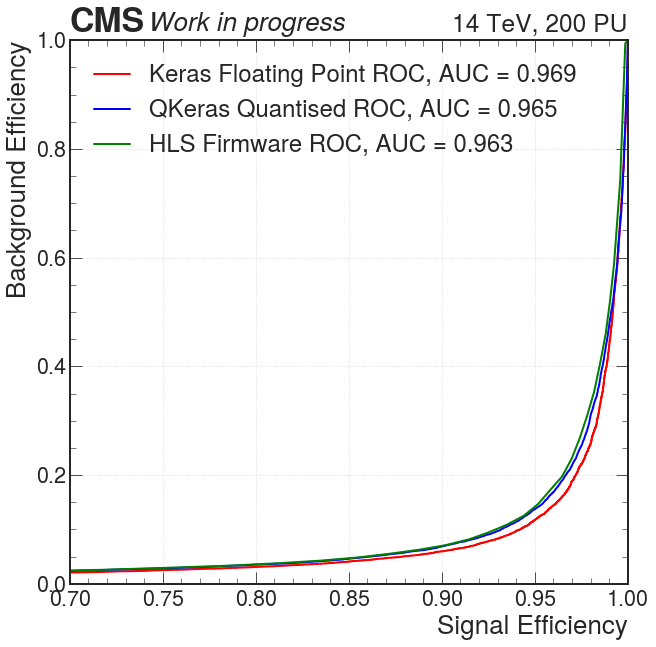

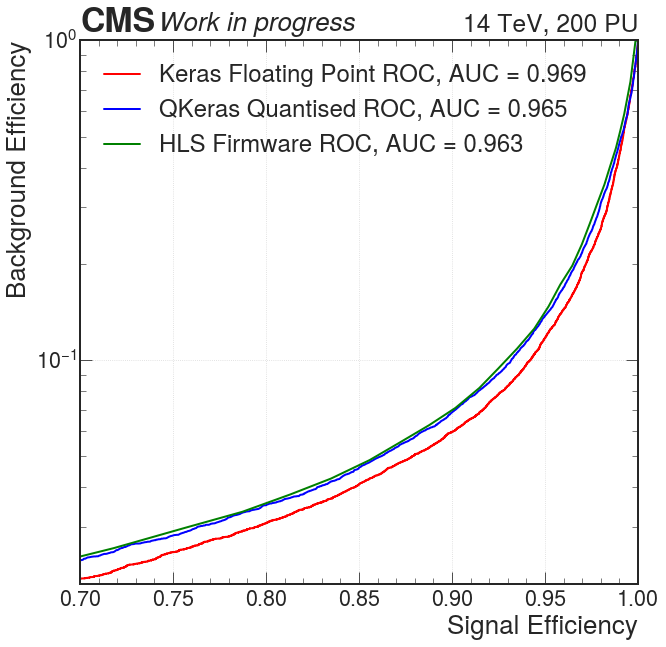

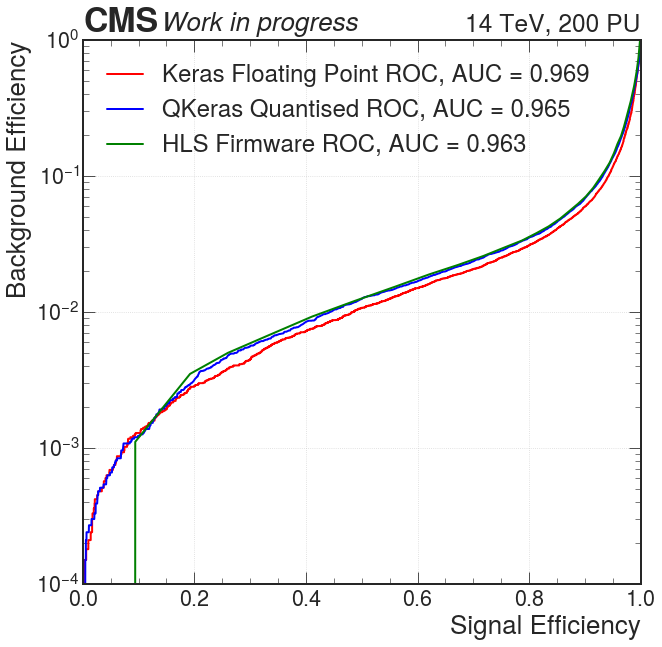

In [14]:
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Xrange=(0.7,1), Yrange=(0,1))
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(Yid,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [15]:
ravelled = Ycal[:,0]

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in progress'))

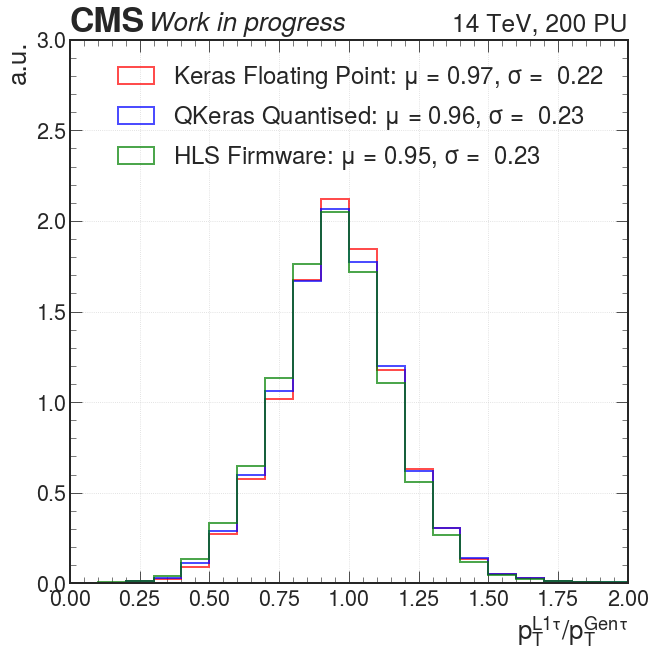

In [16]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Floating Point: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Quantised: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Firmware: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=24)
plt.grid(linestyle='dotted')
mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE HLS MODELS

In [17]:
synth = True
if synth:
    os.environ['PATH'] = '/data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrgrhgtrig.in2p3.fr' (Linux_x86_64 version 3.10.0-957.27.2.el7.x86_64) on Wed Jun 07 14:21:37 CEST 2023
INFO: [HLS 200-10] On os "CentOS Linux release 7.6.1810 (Core) "
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/mot

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:28 . Memory (MB): peak = 1824.188 ; gain = 1295.879 ; free physical = 47631 ; free virtual = 340977
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config6>' (firmware/nnet_utils/nnet_activation.h

INFO: [XFORM 203-131] Reshaping array 'TowerClusterImage.V' (firmware/myproject.cpp:25) in dimension 1 completely.
INFO: [XFORM 203-131] Reshaping array 'TowerClusterPosition.V' (firmware/myproject.cpp:25) in dimension 1 completely.
INFO: [XFORM 203-131] Reshaping array 'AssociatedCl3dFeatures.V' (firmware/myproject.cpp:25) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer11_out.V' (firmware/myproject.cpp:26) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer2_out.V' (firmware/myproject.cpp:55) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer3_out.V' (firmware/myproject.cpp:62) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer4_out.V' (firmware/myproject.cpp:69) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer5_out.V' (firmware/myproject.cpp:76) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer6_out.V' (firmware/myproject.cpp:83) in dime

INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:00:36 ; elapsed = 00:00:40 . Memory (MB): peak = 1824.188 ; gain = 1295.879 ; free physical = 47639 ; free virtual = 340984
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:00:50 ; elapsed = 00:00:53 . Memory (MB): peak = 1824.188 ; gain = 1295.879 ; free physical = 47380 ; free virtual = 340726
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 53.51 seconds; current allocated mem

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.27 seconds; current allocated memory: 602.242 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'PartitionLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.16 seconds; current allocated memory: 604.049 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIN

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate1d_ap_fixed_ap_fixed_ap_fixed_config9_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'concatenate1d_ap_fixed_ap_fixed_ap_fixed_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 1.52 seconds; current allocated memory: 954.224 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate1d_ap_fixed_ap_fixed_ap_fixed_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'concatenate1d_ap_fixed_ap_fixed_ap_fixed_config11_s'.
INFO: [HLS 200-111]  Elapsed time: 0.99 seconds; current allocated memory: 956.213 MB.
INFO: [HLS 200-10] -------------------------------------------------

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_32_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_33_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_34_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_35_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_36_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_37_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_38_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_39_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_40_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_41_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_119_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_120_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_121_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_122_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_123_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_124_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_125_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_126_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_127_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_0_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Im

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_77_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_78_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_79_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_80_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_81_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_82_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_83_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_84_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_85_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_86_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO '

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_2_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_3_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_4_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_5_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_6_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_7_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_8_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_9_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_10_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_11_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO

INFO: [Synth 8-638] synthesizing module 'myproject' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:97]
INFO: [Synth 8-3491] module 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612.vhd:12' bound to instance 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612_U0' of component 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:3774]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5

	Parameter din46_WIDTH bound to: 1 - type: integer 
	Parameter din47_WIDTH bound to: 1 - type: integer 
	Parameter din48_WIDTH bound to: 1 - type: integer 
	Parameter din49_WIDTH bound to: 1 - type: integer 
	Parameter din50_WIDTH bound to: 1 - type: integer 
	Parameter din51_WIDTH bound to: 1 - type: integer 
	Parameter din52_WIDTH bound to: 1 - type: integer 
	Parameter din53_WIDTH bound to: 1 - type: integer 
	Parameter din54_WIDTH bound to: 1 - type: integer 
	Parameter din55_WIDTH bound to: 1 - type: integer 
	Parameter din56_WIDTH bound to: 1 - type: integer 
	Parameter din57_WIDTH bound to: 1 - type: integer 
	Parameter din58_WIDTH bound to: 1 - type: integer 
	Parameter din59_WIDTH bound to: 1 - type: integer 
	Parameter din60_WIDTH bound to: 1 - type: integer 
	Parameter din61_WIDTH bound to: 1 - type: integer 
	Parameter din62_WIDTH bound to: 1 - type: integer 
	Parameter din63_WIDTH bound to: 1 - type: integer 
	Parameter din64_WIDTH bound to: 1 - type: integer 
	Parameter d

	Parameter din55_WIDTH bound to: 1 - type: integer 
	Parameter din56_WIDTH bound to: 1 - type: integer 
	Parameter din57_WIDTH bound to: 1 - type: integer 
	Parameter din58_WIDTH bound to: 1 - type: integer 
	Parameter din59_WIDTH bound to: 1 - type: integer 
	Parameter din60_WIDTH bound to: 1 - type: integer 
	Parameter din61_WIDTH bound to: 1 - type: integer 
	Parameter din62_WIDTH bound to: 1 - type: integer 
	Parameter din63_WIDTH bound to: 1 - type: integer 
	Parameter din64_WIDTH bound to: 1 - type: integer 
	Parameter din65_WIDTH bound to: 1 - type: integer 
	Parameter din66_WIDTH bound to: 1 - type: integer 
	Parameter din67_WIDTH bound to: 1 - type: integer 
	Parameter din68_WIDTH bound to: 1 - type: integer 
	Parameter din69_WIDTH bound to: 1 - type: integer 
	Parameter din70_WIDTH bound to: 1 - type: integer 
	Parameter din71_WIDTH bound to: 1 - type: integer 
	Parameter din72_WIDTH bound to: 1 - type: integer 
	Parameter din73_WIDTH bound to: 1 - type: integer 
	Parameter d

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

	Parameter din37_WIDTH bound to: 14 - type: integer 
	Parameter din38_WIDTH bound to: 14 - type: integer 
	Parameter din39_WIDTH bound to: 14 - type: integer 
	Parameter din40_WIDTH bound to: 14 - type: integer 
	Parameter din41_WIDTH bound to: 14 - type: integer 
	Parameter din42_WIDTH bound to: 14 - type: integer 
	Parameter din43_WIDTH bound to: 14 - type: integer 
	Parameter din44_WIDTH bound to: 14 - type: integer 
	Parameter din45_WIDTH bound to: 14 - type: integer 
	Parameter din46_WIDTH bound to: 14 - type: integer 
	Parameter din47_WIDTH bound to: 14 - type: integer 
	Parameter din48_WIDTH bound to: 14 - type: integer 
	Parameter din49_WIDTH bound to: 14 - type: integer 
	Parameter din50_WIDTH bound to: 14 - type: integer 
	Parameter din51_WIDTH bound to: 14 - type: integer 
	Parameter din52_WIDTH bound to: 14 - type: integer 
	Parameter din53_WIDTH bound to: 14 - type: integer 
	Parameter din54_WIDTH bound to: 14 - type: integer 
	Parameter din55_WIDTH bound to: 14 - type: in

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17_WIDTH bound to: 14 - type: integer 
	Parameter din18_WIDTH bound to: 14 - type: integer 
	Parameter din19_WIDTH bound to: 14 - type: integer 
	P

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612' (4#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_612.vhd:164]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s.vhd:280]
INFO: [Synth 8-256] done synthesizing module 'relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s' (5#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s.vhd:280]
INFO: [Synth 8-638] synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_10_7_5_3_0_config4_

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s' (11#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s.vhd:80]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s.vhd:72]
INFO: [Synth 8-256] done synthesizing module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s' (12#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s.vhd:72]
INFO: [Synth 8-638] synthesizing module 'concatenate1d_ap_fixed_ap_fixed_ap_fixed_config9_s' [/grid_mn

INFO: [Synth 8-256] done synthesizing module 'myproject' (29#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:97]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:22 ; elapsed = 00:00:28 . Memory (MB): peak = 2378.953 ; gain = 108.902 ; free physical = 44461 ; free virtual = 337853
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:24 ; elapsed = 00:00:30 . Memory (MB): peak = 2378.953 ; gain = 108.902 ; free physical = 44420 ; free virtual = 337812
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Ti

No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:01:28 ; elapsed = 00:03:12 . Memory (MB): peak = 3540.758 ; gain = 1270.707 ; free physical = 28513 ; free virtual = 322416
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Technology Mapping
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Technology Mapping : Time (s): cpu = 00:01:31 ; elapsed = 00:03:14 . Memory (MB): peak = 3548.754 ; gain = 1278.703 ; free physical = 28500 ; free virtual = 322418
-

Synthesis Optimization Runtime : Time (s): cpu = 00:01:45 ; elapsed = 00:03:29 . Memory (MB): peak = 3548.754 ; gain = 1278.703 ; free physical = 39758 ; free virtual = 333725
Synthesis Optimization Complete : Time (s): cpu = 00:01:45 ; elapsed = 00:03:29 . Memory (MB): peak = 3548.754 ; gain = 1278.703 ; free physical = 40252 ; free virtual = 334210
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.30 ; elapsed = 00:00:00.30 . Memory (MB): peak = 3548.754 ; gain = 0.000 ; free physical = 42001 ; free virtual = 335959
INFO: [Netlist 29-17] Analyzing 2063 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00 . Memory (MB): peak = 3610.758 ; gain = 0.000 ; free physical = 41838 ; free virtual = 3

In [18]:
synth = True
if synth:
    os.environ['PATH'] = '/data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrgrhgtrig.in2p3.fr' (Linux_x86_64 version 3.10.0-957.27.2.el7.x86_64) on Wed Jun 07 14:28:23 CEST 2023
INFO: [HLS 200-10] On os "CentOS Linux release 7.6.1810 (Core) "
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/ID_DNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms/

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:23 ; elapsed = 00:00:25 . Memory (MB): peak = 1824.188 ; gain = 1295.879 ; free physical = 47745 ; free virtual = 341130
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<7, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<10, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<7, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<7, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<7, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<7, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[13].V' to 'b2.V.13'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[14].V' to 'b2.V.14'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mo

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.16 seconds; current allocated memory: 423.909 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_9_5_0_0_0_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<9,5,0,0,0>,relu_config5>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.24 seconds; current allocated memory: 4


****** Vivado v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source vivado_synth.tcl
# add_files myproject_prj/solution1/syn/vhdl
# synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Command: synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Starting synth_design
Attempting to get a license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: [Common 17-349] Got license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: [Synth 8-7079] Multithreading enabled for synth_design using a maximum of 4 processes.
INFO: [Synth 8-7078] Launching helper process for spawning children vivado processes
INFO: [Synth 8-7075] Helper process launched with PID 234415
---------------------------------------------------------------------------------
Starting Synthesize : Time (s): cpu = 00:00:03 ; elapsed = 00:00:06 . Memory (MB): peak = 2271.516 ; 

INFO: [Synth 8-256] done synthesizing module 'myproject' (9#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/ID_DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:27]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:10 . Memory (MB): peak = 2271.516 ; gain = 0.000 ; free physical = 45844 ; free virtual = 339275
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:06 ; elapsed = 00:00:10 . Memory (MB): peak = 2271.516 ; gain = 0.000 ; free physical = 45840 ; free virtual = 339272
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timi

No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:32 ; elapsed = 00:01:08 . Memory (MB): peak = 3120.828 ; gain = 849.312 ; free physical = 43779 ; free virtual = 337219
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Technology Mapping
---------------------------------------------------------------------------------
INFO: [Synth 8-7052] The timing for the instance sigmoid_table1_U/sigmoid_ap_fixed_ap_fixed_8_1_0_0_0_sigmoid_config7_s_sigbkb_rom_U/q0_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. 

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.09 ; elapsed = 00:00:00.09 . Memory (MB): peak = 3134.703 ; gain = 0.000 ; free physical = 43853 ; free virtual = 337293
INFO: [Netlist 29-17] Analyzing 1272 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00 . Memory (MB): peak = 3250.316 ; gain = 0.000 ; free physical = 43856 ; free virtual = 337290
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 390 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 11 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 378 instances

INFO: [Common 17-83] Releasing

In [19]:
synth = True
if synth:
    os.environ['PATH'] = '/data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/elec_soft/Xilinx_Software/Soft_2020.1/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrgrhgtrig.in2p3.fr' (Linux_x86_64 version 3.10.0-957.27.2.el7.x86_64) on Wed Jun 07 14:31:08 CEST 2023
INFO: [HLS 200-10] On os "CentOS Linux release 7.6.1810 (Core) "
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CAL_DNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/data__data.polcms/cms

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:23 ; elapsed = 00:00:25 . Memory (MB): peak = 1824.188 ; gain = 1295.879 ; free physical = 47493 ; free virtual = 340909
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:26).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:83) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:83) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixe

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[13].V' to 'b2.V.13'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[14].V' to 'b2.V.14'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<11, 6, (ap_q_mode)5, (ap_

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_9_7_0_0_0_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<9,7,0,0,0>,relu_config5>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.19 seconds; current allocated memory: 407.869 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.06 seconds; current allocated memory: 408.187 MB.
INFO: [HLS 200-10] -------------------

INFO: [Synth 8-256] done synthesizing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' (1#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CAL_DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:37]
INFO: [Synth 8-3491] module 'dense_latency_ap_fixed_ap_fixed_config4_0_0_0_0_0_0_0_0_0' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CAL_DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/dense_latency_ap_fixed_ap_fixed_config4_0_0_0_0_0_0_0_0_0.vhd:12' bound to instance 'call_ret2_dense_latency_ap_fixed_ap_fixed_config4_0_0_0_0_0_0_0_0_0_fu_57' of component 'dense_latency_ap_fixed_ap_fixed_config4_0_0_0_0_0_0_0_0_0' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2023_05_28_v16/TauMinator_CE_cltw5x9_Training_QP/CAL_DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:277]
INFO: [Synth 8-638] synthesizing module 'dense_

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln731_58_fu_357_p2, operation Mode is: A*(B:0x1d).
DSP Report: operator mul_ln731_58_fu_357_p2 is absorbed into DSP mul_ln731_58_fu_357_p2.
DSP Report: Generating DSP mul_ln731_47_fu_405_p2, operation Mode is: A*(B:0x3ffe7).
DSP Report: operator mul_ln731_47_fu_405_p2 is absorbed into DSP mul_ln731_47_fu_405_p2.
DSP Report: Generating DSP mul_ln731_27_fu_419_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln731_27_fu_419_p2 is ab

No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:33 ; elapsed = 00:01:09 . Memory (MB): peak = 3114.258 ; gain = 845.309 ; free physical = 43779 ; free virtual = 337249
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Technology Mapping
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Technology Mapping : Time (s): cpu = 00:00:35 ; elapsed = 00:01:12 . Memory (MB): peak = 3158.254 ; gain = 889.305 ; free physical = 43780 ; free virtual = 337250
---

INFO: [Common 17-83] Releasing license: Synthesis
30 Infos, 0 Warnings, 0 Critical Warnings and 0 Errors encountered.
synth_design completed successfully
synth_design: Time (s): cpu = 00:00:49 ; elapsed = 00:01:28 . Memory (MB): peak = 3252.066 ; gain = 995.254 ; free physical = 46080 ; free virtual = 339541
# report_utilization -file vivado_synth.rpt
INFO: [Common 17-206] Exiting Vivado at Wed Jun  7 14:33:38 2023...
***** VIVADO SYNTHESIS COMPLETED IN 0h1m50s *****
INFO: [HLS 200-112] Total elapsed time: 161.37 seconds; peak allocated memory: 446.691 MB.
INFO: [Common 17-206] Exiting vivado_hls at Wed Jun  7 14:33:49 2023...
Cosim report not found.
Timing report not found.
